**1. Testing the Modbus protocol.**
- Default the meter. Verify that your meter is on Modbus protocol, you need to check from the web server application of the meter.
- The meter default IP address is 192.168.0.171.
- You need to change your PC Static IP address to 192.168.0.5.
- Change the meter IP address to 192.168.0.176.
- Connect to the meter via web browser with the IP address 192.168.0.176, prefer to use the Incognito windows.
  1. Open the settings-protocol.
  2. Choose BiLf16 as register set.
  3. Put the master IP= 192.168.0.5 or your PC IP address.
  4. Select Slave Address == 0.
  5. The ip address for the meter is: 192.168.0.176.
- Connect Ethernet cable between the meter and your PC. Verify that the ping is working.
- Press on Shift + Enter to do the test.

In [17]:
import pytest
import sys
import os


# Define the test parameters
TEST_IP = '192.168.0.176'
TEST_PORT = 502
START_ADDRESS = 0
REGISTER_COUNT = 5
SLAVE_ID = 0
EXPECTED_VALUE = 115  # Replace with the actual expected first value

# Run the test function manually
from ModbusTest import read_modbus_registers

print(f"The value for the register modbus {read_modbus_registers(TEST_IP, TEST_PORT, START_ADDRESS, REGISTER_COUNT, SLAVE_ID)}")

Output saved to: modbus_output.txt
The value for the register modbus [0, 239, 238, 238, 26402]


**2. Test the value for register 5, or the voltage value pass a certain value.**
- The value in register 5 is VA-N, I connected to 120 V.
- The Engineering or raw value for this register should be in the range of 26000. Why?
- To convert from Engineering Value to real value we need to do this equation: real_value = (Eng_value/32768)* 150 * Pt.
- Since Pt = 1. and I am reading 26445, then the real value will be = (26445/32768)*150 = 121.055.
- with this value is passing then we know that the Modbus is working good.

In [18]:
from pymodbus.exceptions import ModbusException


# Define test parameters
TEST_IP = '192.168.0.176'
TEST_PORT = 502
START_ADDRESS = 0
REGISTER_COUNT = 5
SLAVE_ID = 0
EXPECTED_VALUE = 26000 # Replace with the actual expected first value

# Print the value from Modbus
try:
    values = read_modbus_registers(TEST_IP, TEST_PORT, START_ADDRESS, REGISTER_COUNT, SLAVE_ID)
    print("The value for the register modbus: ", values)

    # Manual test case instead of pytest
    assert values[4] >= EXPECTED_VALUE, f"Test failed: Expected {EXPECTED_VALUE}, but got {values[4]}"
    print("Test passed!")
except ModbusException as e:
    print(f"Modbus exception occurred: {e}")
except AssertionError as e:
    print(e)
except Exception as e:
    print(f"Unexpected error: {e}")


Output saved to: modbus_output.txt
The value for the register modbus:  [0, 235, 236, 235, 26403]
Test passed!


**3. Test the Responding Time for Modbus in the meter**

In [19]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# 
# !python Respond_Time_Modbus.py
# import matplotlib.pyplot as plt



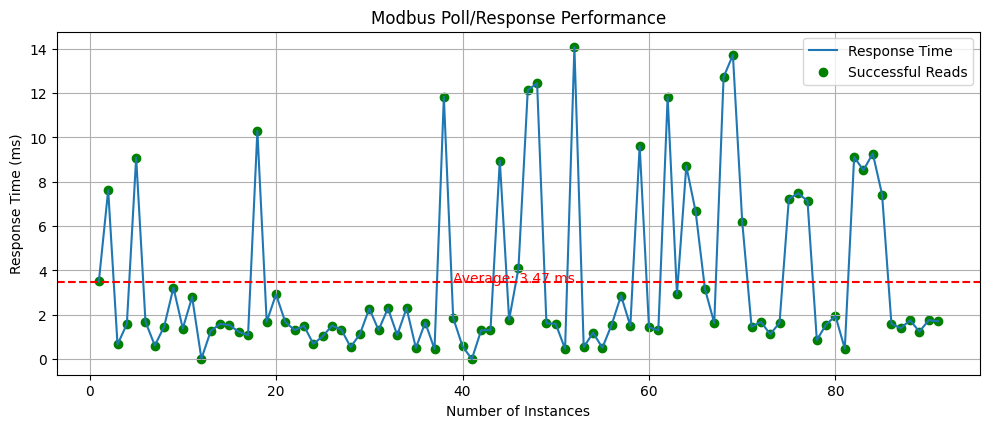

In [20]:
import time
from pymodbus.client import ModbusTcpClient
import pandas as pd
import matplotlib.pyplot as plt
# Add this line to render plots inline
%matplotlib inline
# Add this line to render plots inline

# Configuration
meter_ip = '192.168.0.176'
register_count = 40
polling_interval = 100  # in milliseconds
polling_duration = 10  # in seconds

# Initialize Modbus client
client = ModbusTcpClient(meter_ip)

# Check if client connection is successful
if not client.connect():
    print(f"Failed to connect to Modbus server at {meter_ip}")
else:
    # Data collection
    response_times = []
    instance_counts = []
    interval_times = []
    successful_polls = 0
    failed_polls = 0
    read_durations = []
    successful_reads = []
    registers_read = []
    all_registers_values = []

    # Function to poll data
    def poll_data(client, count, last_poll_time, successful_polls, failed_polls):
        start_time = time.time()
        response = client.read_holding_registers(0, register_count)
        end_time = time.time()
        response_time = (end_time - start_time) * 1000  # Convert to milliseconds

        if response.isError():
            print(f"Poll {count}: Error reading registers")
            failed_polls += 1
        else:
            response_times.append(response_time)
            instance_counts.append(count)
            interval_time = (start_time - last_poll_time) * 1000  # Convert to milliseconds
            interval_times.append(interval_time)
            successful_polls += 1

            # Calculate the read duration
            read_duration = (end_time - start_time) * 1000  # Convert to milliseconds
            read_durations.append(read_duration)
            successful_reads.append(count)

            # Check how many registers were read
            num_registers = len(response.registers)
            registers_read.append(num_registers)

            # Save the values of each register
            all_registers_values.append(response.registers)

            # Print the values of each register
            # print(f"Poll {count}: Successfully read {num_registers} registers")
            # for i, value in enumerate(response.registers):
            #     print(f"Register {i + 1}: {value}")

        return end_time, successful_polls, failed_polls

    # Polling loop
    count = 1
    start_time = time.time()
    last_poll_time = start_time
    while time.time() - start_time < polling_duration:
        last_poll_time, successful_polls, failed_polls = poll_data(client, count, last_poll_time, successful_polls, failed_polls)
        count += 1
        time.sleep(polling_interval / 1000.0)

    client.close()

    # Save data to DataFrame and then to Excel file
    df = pd.DataFrame(all_registers_values, columns=[f'Register {i+1}' for i in range(register_count)])
    df.index.name = 'Poll Number'
    df.to_excel('register_values.xlsx')

    # Calculate average response time
    if response_times:
        average_response_time = sum(response_times) / len(response_times)
        #print(f"Average Response Time: {average_response_time:.2f} ms")

    # Data Analysis and Visualization
    plt.figure(figsize=(10, 16))

    # Plot response times
    plt.subplot(4, 1, 1)
    plt.plot(instance_counts, response_times, label='Response Time')
    plt.scatter(successful_reads, [response_times[i] for i in range(len(response_times)) if instance_counts[i] in successful_reads], color='green', marker='o', label='Successful Reads')
    plt.axhline(y=average_response_time, color='r', linestyle='--')
    plt.text(len(instance_counts) / 2, average_response_time, f'Average: {average_response_time:.2f} ms', color='red', ha='center')
    plt.xlabel('Number of Instances')
    plt.ylabel('Response Time (ms)')
    plt.legend()
    plt.title('Modbus Poll/Response Performance')
    plt.grid(True)

    # # Plot interval times
    # plt.subplot(4, 1, 2)
    # plt.plot(instance_counts, interval_times, label='Interval Time', color='orange')
    # plt.scatter(successful_reads, [interval_times[i] for i in range(len(interval_times)) if instance_counts[i] in successful_reads], color='green', marker='o', label='Successful Reads')
    # plt.xlabel('Number of Instances')
    # plt.ylabel('Interval Time (ms)')
    # plt.legend()
    # plt.title('Polling Interval Times')
    # plt.grid(True)
    # 
    # # Plot read durations
    # plt.subplot(4, 1, 3)
    # plt.plot(instance_counts, read_durations, label='Read Duration', color='green')
    # plt.scatter(successful_reads, [read_durations[i] for i in range(len(read_durations)) if instance_counts[i] in successful_reads], color='red', marker='o', label='Successful Reads')
    # plt.xlabel('Number of Instances')
    # plt.ylabel('Read Duration (ms)')
    # plt.legend()
    # plt.title('Read Duration Times')
    # plt.grid(True)
    # 
    # # Plot number of registers read
    # plt.subplot(4, 1, 4)
    # plt.plot(successful_reads, registers_read, label='Registers Read', color='blue')
    # plt.scatter(successful_reads, registers_read, color='purple', marker='o', label='Successful Reads')
    # plt.xlabel('Number of Instances')
    # plt.ylabel('Registers Read')
    # plt.legend()
    # plt.title('Number of Registers Read')
    # plt.grid(True)

    plt.tight_layout()
    plt.show()

    # # Print summary of polling results
    # print(f"Successful Polls: {successful_polls}")
    # print(f"Failed Polls: {failed_polls}")
    # print(f"Read Durations: {read_durations}")
    # print(f"Registers Read: {registers_read}")


In [21]:
# # Plot response times
# plt.figure(figsize=(10, 4))
# plt.plot(instance_counts, response_times, label='Response Time')
# plt.scatter(successful_reads, [response_times[i] for i in range(len(response_times)) if instance_counts[i] in successful_reads], color='green', marker='o', label='Successful Reads')
# plt.axhline(y=average_response_time, color='r', linestyle='--')
# plt.text(len(instance_counts) / 2, average_response_time, f'Average: {average_response_time:.2f} ms', color='red', ha='center')
# plt.xlabel('Number of Instances')
# plt.ylabel('Response Time (ms)')
# plt.legend()
# plt.title('Modbus Poll/Response Performance')
# plt.grid(True)
# plt.show()


In [22]:
# # Plot interval times
# plt.figure(figsize=(10, 4))
# plt.plot(instance_counts, interval_times, label='Interval Time', color='orange')
# plt.scatter(successful_reads, [interval_times[i] for i in range(len(interval_times)) if instance_counts[i] in successful_reads], color='green', marker='o', label='Successful Reads')
# plt.xlabel('Number of Instances')
# plt.ylabel('Interval Time (ms)')
# plt.legend()
# plt.title('Polling Interval Times')
# plt.grid(True)
# plt.show()


In [23]:
# # Plot read durations
# plt.figure(figsize=(10, 4))
# plt.plot(instance_counts, read_durations, label='Read Duration', color='green')
# plt.scatter(successful_reads, [read_durations[i] for i in range(len(read_durations)) if instance_counts[i] in successful_reads], color='red', marker='o', label='Successful Reads')
# plt.xlabel('Number of Instances')
# plt.ylabel('Read Duration (ms)')
# plt.legend()
# plt.title('Read Duration Times')
# plt.grid(True)
# plt.show()


In [24]:
# # Plot number of registers read
# plt.figure(figsize=(10, 4))
# plt.plot(successful_reads, registers_read, label='Registers Read', color='blue')
# plt.scatter(successful_reads, registers_read, color='purple', marker='o', label='Successful Reads')
# plt.xlabel('Number of Instances')
# plt.ylabel('Registers Read')
# plt.legend()
# plt.title('Number of Registers Read')
# plt.grid(True)
# plt.show()
